In [1]:
import pandas as pd
import numpy as np
from gurobipy import Model, GRB
from gurobipy import quicksum
import gurobipy as gp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style ="whitegrid", font_scale=1.5)

# Demand File Processing & Viz

In [2]:
DTLA = pd.read_csv('../input/schedule_5min_0612.csv').reset_index()
LGB = pd.read_csv('../input/demand_variation/schedule/alpha_7_demand_1500/7_1.csv').reset_index()
WDHL = pd.read_csv('../input/demand_variation/schedule/alpha_7_demand_500/6_1.csv').reset_index()
ELSG = pd.read_csv('../input/demand_variation/schedule/alpha_7_demand_2500/5_1.csv').reset_index()
UVS = pd.read_csv('../input/demand_variation/schedule/alpha_7_demand_500/3_1.csv').reset_index()

In [3]:
DTLA['schedule'] = np.ceil(DTLA['schedule']/5)
LGB['schedule'] = np.ceil(LGB['schedule']/5)
WDHL['schedule'] = np.ceil(WDHL['schedule']/5)
UVS['schedule'] = np.ceil(UVS['schedule']/5)

DTLA['origin'] = DTLA['od'].apply(lambda x: 0 if x.split('_')[0] == 'LAX' else 1)
LGB['origin'] = LGB['od'].apply(lambda x: 0 if x.split('_')[0] == 'LAX' else 2)
WDHL['origin'] = WDHL['od'].apply(lambda x: 0 if x.split('_')[0] == 'LAX' else 3)
UVS['origin'] = UVS['od'].apply(lambda x: 0 if x.split('_')[0] == 'LAX' else 4)

DTLA['destination'] = DTLA['od'].apply(lambda x: 0 if x.split('_')[1] == 'LAX' else 1)
LGB['destination'] = LGB['od'].apply(lambda x: 0 if x.split('_')[1] == 'LAX' else 2)
WDHL['destination'] = WDHL['od'].apply(lambda x: 0 if x.split('_')[1] == 'LAX' else 3)
UVS['destination'] = UVS['od'].apply(lambda x: 0 if x.split('_')[1] == 'LAX' else 4)

In [4]:
def get_num_flight_both_dir(leg_demand, agg_window):
    LAX_X = leg_demand[leg_demand['origin'] == 0]['schedule'].to_numpy() / (12)
    X_LAX = leg_demand[leg_demand['destination'] == 0]['schedule'].to_numpy() / (12)
    
    LAX_X_hourly = np.histogram(LAX_X, bins = agg_window)[0]
    X_LAX_hourly = np.histogram(X_LAX, bins = agg_window)[0]

    return LAX_X_hourly, X_LAX_hourly

def plot_single_leg(num_flight, label, color, ax):
    LAX_X_hourly, X_LAX_hourly = num_flight
    LAX_X_label, X_LAX_label = label
    LAX_X_color, X_LAX_color = color

    sns.lineplot(y=LAX_X_hourly, x=agg_window[:-1], 
             linewidth=1, ax=ax[0], label=LAX_X_label, marker='o', color=LAX_X_color)
    sns.lineplot(y=X_LAX_hourly, x=agg_window[:-1], 
                linewidth=1, ax=ax[1], label=X_LAX_label, marker='o', color=X_LAX_color)



In [5]:
from matplotlib.ticker import MultipleLocator
import matplotlib
color_platte = ['#93003a', '#00429d', '#93c4d2', '#6ebf7c']
matplotlib.rcParams.update({'legend.fontsize': 14, 'legend.handlelength': 2})

agg_window = np.arange(0, 25, 1)

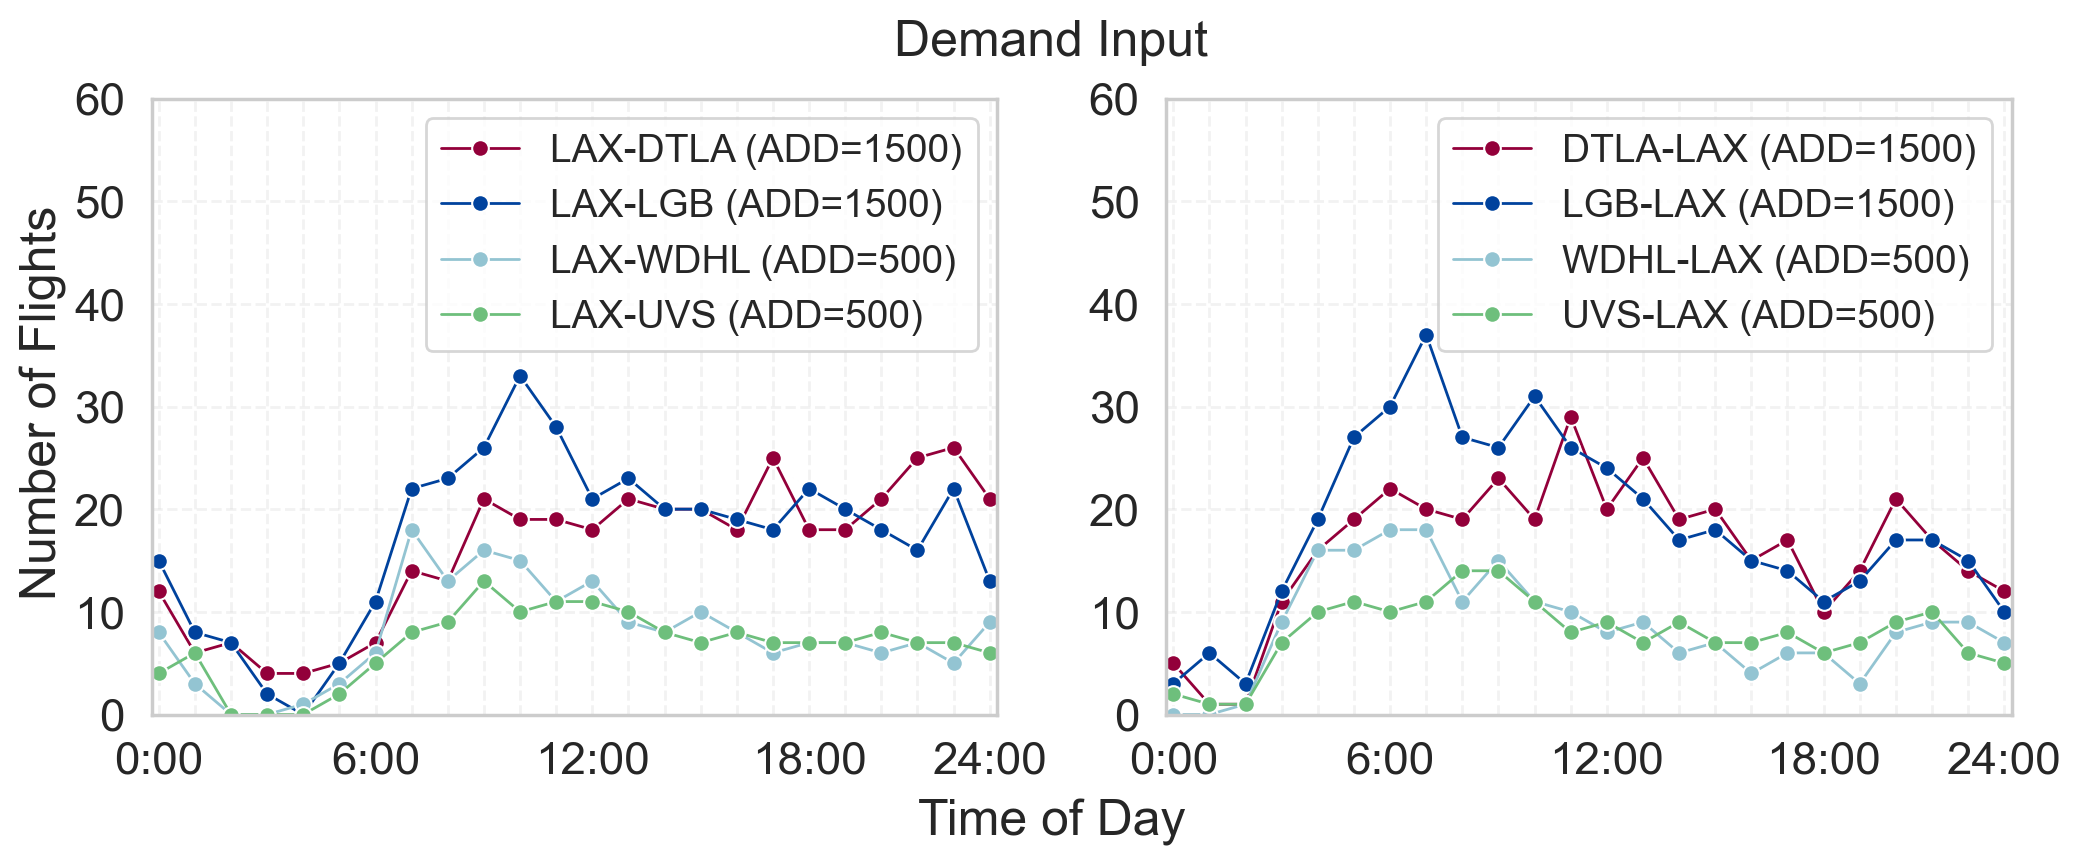

In [7]:
fig, ax = plt.subplots(dpi=200, figsize=(12,4), ncols=2)

LAX_DTLA_hourly, DTLA_LAX_hourly = get_num_flight_both_dir(DTLA, agg_window)
plot_single_leg((LAX_DTLA_hourly, DTLA_LAX_hourly), 
                ('LAX-DTLA (ADD=1500)', 'DTLA-LAX (ADD=1500)'), 
                (color_platte[0], color_platte[0]), ax)

LAX_LGB_hourly, LGB_LAX_hourly = get_num_flight_both_dir(LGB, agg_window)
plot_single_leg((LAX_LGB_hourly, LGB_LAX_hourly), 
                ('LAX-LGB (ADD=1500)', 'LGB-LAX (ADD=1500)'), 
                (color_platte[1], color_platte[1]), ax)

LAX_WDHL_hourly, WDHL_LAX_hourly = get_num_flight_both_dir(WDHL, agg_window)
plot_single_leg((LAX_WDHL_hourly, WDHL_LAX_hourly), 
                ('LAX-WDHL (ADD=500)', 'WDHL-LAX (ADD=500)'), 
                (color_platte[2], color_platte[2]), ax)

LAX_UVS_hourly, UVS_LAX_hourly = get_num_flight_both_dir(UVS, agg_window)
plot_single_leg((LAX_UVS_hourly, UVS_LAX_hourly), 
                ('LAX-UVS (ADD=500)', 'UVS-LAX (ADD=500)'), 
                (color_platte[3], color_platte[3]), ax)

minorLocator = MultipleLocator(1)
for i in range(2):
    ax[i].set(xlabel='', ylabel='', 
                xticks=[0,6,12,18,24-1], xticklabels=['0:00', '6:00', '12:00', '18:00', '24:00'],
                ylim=(0,60),
                xlim=(-0.2,23.2));
    ax[i].xaxis.set_minor_locator(minorLocator)
    ax[i].grid(True, alpha=0.25, linestyle='--', which='both')

fig.text(0.5, 0.95, 'Demand Input', ha='center', va='center')
fig.text(0.08, 0.5, 'Number of Flights', ha='center', va='center', rotation='vertical')
fig.text(0.5, -0.025, 'Time of Day', ha='center', va='center');


# Upper Bound with Assignment Problem

In [8]:
import src.topo
import importlib
importlib.reload(src.topo)
from src.topo import AssignmentNetwork, FlightTask
from tqdm import tqdm

## Build out the network and tasks

In [99]:
flight_time = np.array([[0,2,3,4,4],
                        [2,0,5,6,6],
                        [3,5,0,7,7],
                        [4,6,7,0,8],
                        [4,6,7,8,0]])

charging_time = np.array([[0,1,1,2,2],
                          [1,0,2,3,3],
                          [1,2,0,3,3],
                          [2,3,3,0,4],
                          [2,3,3,4,0]])

repurposing_time = flight_time + charging_time

all_tasks = []    
for i, row in DTLA.iterrows():
    all_tasks.append(FlightTask('DTLA_'+str(row['index']), int(row['schedule']), repurposing_time, row['origin'], row['destination']))
for i, row in LGB.iterrows():
    all_tasks.append(FlightTask('LGB_'+str(row['index']), int(row['schedule']), repurposing_time, row['origin'], row['destination']))
for i, row in WDHL.iterrows():
    all_tasks.append(FlightTask('WDHL_'+str(row['index']), int(row['schedule']), repurposing_time, row['origin'], row['destination']))
for i, row in UVS.iterrows():
    all_tasks.append(FlightTask('UVS_'+str(row['index']), int(row['schedule']), repurposing_time, row['origin'], row['destination']))

all_tasks = sorted(all_tasks, key=lambda x: x.start_time)

In [100]:
network = AssignmentNetwork(all_tasks)
nodes, supply, edges, cost, c = network.populate_network()

## Solve the problem

In [101]:
m = Model("MCNF")

flow = m.addVars(edges, obj=cost, name="flow", lb=0)
for n in tqdm(nodes):
    m.addConstr(sum(flow[i, j] for i, j in edges if j == n) -
                sum(flow[i, j] for i, j in edges if i == n) == supply.get(n, 0), f"node_{n}")

for edge in tqdm(edges):
    edge_source = edge[0]
    edge_target = edge[1]
    if len(edge_source) == 2 & len(edge_target) == 2:
        if edge_source[0] == edge_target[0]:
            if (edge_source[1] == 'start') & (edge_target[1] == 'finish'):
                m.addConstr(flow[edge_source, edge_target] == 1, f"flow_{edge_source}_to_{edge_target}")
    
m.setParam('OutputFlag', 0)                
m.optimize()
print('Optimal Fleetsize: %g' % m.objVal)

KeyboardInterrupt: 

In [ ]:
with open('../output/star_network/assignment/NETWORK.txt', 'w') as f:
    for v in m.getVars():
        f.write(f'{v.varName} = {v.x}\n')

# Comparison to the IP Formulation

In [ ]:
import os
os.chdir('../')
from model.op import FleetSizeOptimizer

In [ ]:
fso_DTLA = FleetSizeOptimizer(flight_time=np.array([[0,10],[10,0]]), 
                              energy_consumption=np.array([[0,10],[10,0]]), 
                              schedule='schedule_5min_0612.csv')
fso_DTLA.optimize(output_path='star_network/DTLA', optimality_gap=0.01, verbose=False)


fso_LGB = FleetSizeOptimizer(flight_time=np.array([[0,15],[15,0]]),
                             energy_consumption=np.array([[0,10],[10,0]]), 
                             schedule='demand_variation/schedule/alpha_7_demand_1500/7_1.csv')
fso_LGB.optimize(output_path='star_network/LGB', optimality_gap=0.01, verbose=False)

fso_WDHL = FleetSizeOptimizer(flight_time=np.array([[0,20],[20,0]]),
                              energy_consumption=np.array([[0,10],[10,0]]), 
                              schedule='demand_variation/schedule/alpha_7_demand_500/6_1.csv')
fso_WDHL.optimize(output_path='star_network/WDHL', optimality_gap=0.01, verbose=False)

fso_UVS = FleetSizeOptimizer(flight_time=np.array([[0,25],[25,0]]),
                             energy_consumption=np.array([[0,10],[10,0]]), 
                             schedule='demand_variation/schedule/alpha_7_demand_500/3_1.csv')
fso_UVS.optimize(output_path='star_network/UVS', optimality_gap=0.01, verbose=False)



14

# Lower Bound with LRP

In [8]:
import src.topo
import importlib
importlib.reload(src.topo)
from src.topo import AssignmentNetwork, FlightTask, ChargingNetwork
from tqdm import tqdm
import pickle

## Build out the network

In [9]:
vertiports = ['LAX', 'DTLA', 'LGB', 'WDHL', 'UVS']

flight_time = np.array([[0,2,3,4,4],
                        [2,0,5,6,6],
                        [3,5,0,7,7],
                        [4,6,7,0,8],
                        [4,6,7,8,0]])

# Units for energy consumption is levels of %SoC
energy_consumption = np.array([[0,10,15,20,25],
                               [10,0,25,30,35],
                               [15,25,0,35,35],
                               [20,30,35,0,40],
                               [25,35,35,40,0]]) / 2.5
energy_consumption = energy_consumption.astype(int)

od_matrix = np.array([[0,1,1,1,1],
                      [1,0,1,1,1],
                      [1,1,0,1,1],
                      [1,1,1,0,1],
                      [1,1,1,1,0]])

In [10]:
network2 = ChargingNetwork(vertiports, flight_time, energy_consumption, od_matrix)
nodes, supply, edges, cost, c = network2.populate_network()

In [11]:
def obtain_demand_dict(df, existing_dict=None):
    if existing_dict is not None:
        demand_dict = existing_dict
    else:
        demand_dict = {}
        
    df_grouped = df.groupby(['origin', 'destination', 'schedule']).size().reset_index(name='count')
    for i, row in df_grouped.iterrows():
        demand_dict[(int(row['origin']), int(row['destination']), int(row['schedule']))] = int(row['count'])
    return demand_dict

In [12]:
od_key = {'LAX':0, 'DTLA':1, 'LGB':2, 'WDHL':3, 'UVS':4}
flight_demand = obtain_demand_dict(DTLA)
flight_demand = obtain_demand_dict(LGB, flight_demand)
flight_demand = obtain_demand_dict(WDHL, flight_demand)
flight_demand = obtain_demand_dict(UVS, flight_demand)

## Solve the problem

In [45]:
model_name = 'NETWORK_Gurobipy_0507'

In [46]:
m = Model("LagrangianRelaxation")
# Create variables
var_keys = m.addVars(edges, name=lambda e: f"flow_{e[0]}_{e[1]}", lb=0)
# Create flow conservation constraints
m.setParam('Threads', 4)
for n in tqdm(nodes):
    m.addConstr(quicksum(var_keys[i, j] for i, j in edges if j == n) -
    quicksum(var_keys[i, j] for i, j in edges if i == n) == supply.get(n, 0), f"node_{n}")
m.update()
m.write(f'../output/star_network/LR/{model_name}.mps')

Set parameter Threads to value 4


100%|██████████| 48842/48842 [32:39<00:00, 24.93it/s]


In [13]:
def get_flight_edges(i, model_param, flight_time=flight_time, energy_consumption=energy_consumption):
    K = 32
    v1, v2, t = i
    flight_time_ij = flight_time[v1, v2]
    soc_level_drop = int(energy_consumption[v1, v2])

    volume = quicksum(model_param[(v1, t, k), (v2, t+flight_time_ij, k-soc_level_drop)] for k in range(soc_level_drop, K+1))
    
    return volume
    

### Linear Relaxation

In [101]:
lm = gp.read(f'../output/star_network/LR/{model_name}.mps')

flow_vars = lm.getVars()
flow = {edges[idx]: flow_vars[idx] for idx in range(len(flow_vars))}

for i in flight_demand.keys():
    lm.addConstr(get_flight_edges(i, flow) >= flight_demand[i], name=f'demand_constraint_{i}')

objective = quicksum(c[i,j] * flow[i,j] for i,j in edges)
lm.setObjective(objective, GRB.MINIMIZE)
lm.relax()
lm.optimize()
lm.objVal


Read MPS format model from file ../output/star_network/LR/NETWORK_Gurobipy_0507.mps
Reading time = 0.24 seconds
LagrangianRelaxation: 48842 rows, 943664 columns, 1887328 nonzeros
Derived model does not contain these changes.
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 50465 rows, 943664 columns and 1930129 nonzeros
Model fingerprint: 0xc821286e
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 470 rows and 4623 columns
Presolve time: 0.75s
Presolved: 49995 rows, 939041 columns, 1920883 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 2.88s

Barrier statistics:
 AA' NZ     : 1.024e+06
 Factor NZ  : 7.185e+07 (roughly 1.0 GB of memory)
 Factor Ops : 

56.68723433501528

In [102]:
x0 = {edges[idx]: flow_vars[idx].X for idx in range(len(flow_vars))}

In [36]:
dual_prices = {}
for constr in lm.getConstrs():
    if constr.ConstrName.startswith('demand_constraint'):
        dual_prices[constr.ConstrName] = constr.Pi
print("Dual prices:", dual_prices)
dual_price = np.abs(np.array(list(dual_prices.values())))

dual_price = {i: dual_price[idx] for idx, i in enumerate(flight_demand.keys())}
with open('../output/star_network/LR/dual_prices.pkl', 'wb') as f:
    pickle.dump(dual_price, f)

Dual prices: {'demand_constraint_(0, 1, 1)': -0.0, 'demand_constraint_(0, 1, 2)': -0.0, 'demand_constraint_(0, 1, 3)': -0.0, 'demand_constraint_(0, 1, 4)': 0.0, 'demand_constraint_(0, 1, 5)': -0.0, 'demand_constraint_(0, 1, 6)': -0.0, 'demand_constraint_(0, 1, 7)': 0.0, 'demand_constraint_(0, 1, 8)': -0.0, 'demand_constraint_(0, 1, 9)': -0.0, 'demand_constraint_(0, 1, 10)': -0.0, 'demand_constraint_(0, 1, 11)': -0.0, 'demand_constraint_(0, 1, 12)': -0.0, 'demand_constraint_(0, 1, 14)': -0.0, 'demand_constraint_(0, 1, 15)': -0.0, 'demand_constraint_(0, 1, 18)': -0.0, 'demand_constraint_(0, 1, 21)': -0.0, 'demand_constraint_(0, 1, 23)': -0.0, 'demand_constraint_(0, 1, 24)': 4.240482418038649e-05, 'demand_constraint_(0, 1, 25)': 4.2404824180442e-05, 'demand_constraint_(0, 1, 27)': 4.2404824180497513e-05, 'demand_constraint_(0, 1, 29)': 8.942371138709326e-05, 'demand_constraint_(0, 1, 31)': 8.942371138709326e-05, 'demand_constraint_(0, 1, 32)': 8.942371138709326e-05, 'demand_constraint_(0,

### Lagragian Relaxation

### Using Cutting Plane

##### Generate inititial feasible solution

In [14]:
model_name = 'NETWORK_Gurobipy_0507'

In [18]:
# Generate initial feasible x
cp = gp.read(f'../output/star_network/LR/{model_name}.mps')
lambda_s = {i: 10 for i in flight_demand.keys()}

flow_vars = cp.getVars()
flow = {edges[idx]: flow_vars[idx] for idx in range(len(flow_vars))}

# primal_objective = quicksum(c[i,j] * flow[i,j] for i,j in edges)
# lagragian_dual_objective = quicksum(lambda_s[i] * (flight_demand[i] - get_flight_edges(i, flow)) for i in flight_demand.keys())
    
# cp.setObjective(primal_objective + lagragian_dual_objective, GRB.MINIMIZE)
# cp.setParam('OutputFlag', 0)
# cp.optimize()


# x0 = {edges[idx]: flow_vars[idx].X for idx in range(len(flow_vars))}

Read MPS format model from file ../output/star_network/LR/NETWORK_Gurobipy_0507.mps
Reading time = 0.26 seconds
LagrangianRelaxation: 48842 rows, 943664 columns, 1887328 nonzeros


#### Solve the maximization problem

In [165]:
def solve_for_u(list_of_x, ub=1):
    cp = gp.read(f'../output/star_network/LR/{model_name}.mps')
    z = cp.addVar(name='z')

    lambda_s = cp.addVars(flight_demand.keys(), name='lambda', lb=0, ub=ub)
    cp.update()

    for i in range(len(list_of_x)):
        x = list_of_x[i]
        cp.addConstr(z <= quicksum(c[i,j] * x[i,j] for i,j in edges) + quicksum(lambda_s[i] * (flight_demand[i]-get_flight_edges(i, x).getValue()) for i in flight_demand.keys()))

    cp.setObjective(z, GRB.MAXIMIZE)
    cp.setParam('OutputFlag', 0)
    cp.optimize()


    return cp.objVal, {i: lambda_s[i].X for i in flight_demand.keys()}


In [173]:
def solve_for_x(list_of_u=None, list_of_z=None):
    cp = gp.read(f'../output/star_network/LR/{model_name}.mps')

    flow_vars = cp.getVars()
    flow = {edges[idx]: flow_vars[idx] for idx in range(len(flow_vars))}

    primal_objective = quicksum(c[i,j] * flow[i,j] for i,j in edges) + quicksum(list_of_u[i][j] * (flight_demand[j] - get_flight_edges(j, flow)) for j in flight_demand.keys())


    if list_of_u is not None:
        for i in range(len(list_of_u)):
            cp.addConstr(list_of_z[i] <= )

    cp.setObjective(primal_objective, GRB.MINIMIZE)
    cp.setParam('OutputFlag', 0)
    cp.optimize()

    x0 = {edges[idx]: flow_vars[idx].X for idx in range(len(flow_vars))}

    '''
    this function should return:
    1. gradient with respect to lambda
    2. primal objective value
    '''


    return cp.objVal, x0


def get_cut():

    '''
    return the linear function of the cut in terms of lambda
    '''
        

In [171]:
from tqdm import tqdm
list_of_z = []
list_of_u = []
list_of_x = []
list_of_x.append(x0)
list_of_objval = []

for i in tqdm(range(3)):
    z, u = solve_for_u(list_of_x, ub=10)
    list_of_z.append(z)
    list_of_u.append(u)
    objval, x = solve_for_x(list_of_u, list_of_z)
    list_of_x.append(x)
    list_of_objval.append(objval)


  0%|          | 0/3 [00:00<?, ?it/s]

Read MPS format model from file ../output/star_network/LR/NETWORK_Gurobipy_0507.mps
Reading time = 0.22 seconds
LagrangianRelaxation: 48842 rows, 943664 columns, 1887328 nonzeros
Read MPS format model from file ../output/star_network/LR/NETWORK_Gurobipy_0507.mps
Reading time = 0.21 seconds
LagrangianRelaxation: 48842 rows, 943664 columns, 1887328 nonzeros


 33%|███▎      | 1/3 [00:28<00:57, 28.99s/it]

Read MPS format model from file ../output/star_network/LR/NETWORK_Gurobipy_0507.mps
Reading time = 0.21 seconds
LagrangianRelaxation: 48842 rows, 943664 columns, 1887328 nonzeros
Read MPS format model from file ../output/star_network/LR/NETWORK_Gurobipy_0507.mps
Reading time = 0.21 seconds
LagrangianRelaxation: 48842 rows, 943664 columns, 1887328 nonzeros


 67%|██████▋   | 2/3 [00:57<00:28, 28.87s/it]

Read MPS format model from file ../output/star_network/LR/NETWORK_Gurobipy_0507.mps
Reading time = 0.21 seconds
LagrangianRelaxation: 48842 rows, 943664 columns, 1887328 nonzeros
Read MPS format model from file ../output/star_network/LR/NETWORK_Gurobipy_0507.mps
Reading time = 0.21 seconds
LagrangianRelaxation: 48842 rows, 943664 columns, 1887328 nonzeros


100%|██████████| 3/3 [01:28<00:00, 29.36s/it]


#### Chiwei's version

In [174]:
def solve_for_u(list_of_x, ub=1):
    cp = gp.read(f'../output/star_network/LR/{model_name}.mps')
    z = cp.addVar(name='z')

    lambda_s = cp.addVars(flight_demand.keys(), name='lambda', lb=0, ub=ub)
    cp.update()

    for i in range(len(list_of_x)):
        x = list_of_x[i]
        cp.addConstr(z >= quicksum(c[i,j] * x[i,j] for i,j in edges) + quicksum(lambda_s[i] * (flight_demand[i]-get_flight_edges(i, x).getValue()) for i in flight_demand.keys()))

    cp.setObjective(z, GRB.MINIMIZE)
    cp.setParam('OutputFlag', 0)
    cp.optimize()


    return cp.objVal, {i: lambda_s[i].X for i in flight_demand.keys()}


In [208]:
def solve_for_x(one_u):
    cp = gp.read(f'../output/star_network/LR/{model_name}.mps')

    flow_vars = cp.getVars()
    flow = {edges[idx]: flow_vars[idx] for idx in range(len(flow_vars))}
    cp.update()
    
    primal_objective = quicksum(c[i,j] * flow[i,j] for i,j in edges)
    dual_objective = quicksum(one_u[i] * (flight_demand[i] - get_flight_edges(i, flow)) for i in flight_demand.keys())
        

    cp.setObjective(primal_objective+dual_objective, GRB.MINIMIZE)
    cp.setParam('OutputFlag', 0)
    cp.optimize()

    x0 = {edges[idx]: flow_vars[idx].X for idx in range(len(flow_vars))}

    return cp.objVal, x0
        

In [220]:
from tqdm import tqdm
list_of_z = []
list_of_u = []
list_of_x = []
list_of_x.append(x0)
list_of_objval = []

for i in tqdm(range(3)):
    z, u = solve_for_u(list_of_x, ub=1)
    list_of_z.append(z)
    list_of_u.append(u)
    objval, x = solve_for_x(u)
    list_of_x.append(x)
    list_of_objval.append(objval)


  0%|          | 0/3 [00:00<?, ?it/s]

Read MPS format model from file ../output/star_network/LR/NETWORK_Gurobipy_0507.mps
Reading time = 0.25 seconds
LagrangianRelaxation: 48842 rows, 943664 columns, 1887328 nonzeros
Read MPS format model from file ../output/star_network/LR/NETWORK_Gurobipy_0507.mps
Reading time = 0.20 seconds
LagrangianRelaxation: 48842 rows, 943664 columns, 1887328 nonzeros


 33%|███▎      | 1/3 [00:10<00:21, 10.60s/it]

Read MPS format model from file ../output/star_network/LR/NETWORK_Gurobipy_0507.mps
Reading time = 0.21 seconds
LagrangianRelaxation: 48842 rows, 943664 columns, 1887328 nonzeros
Read MPS format model from file ../output/star_network/LR/NETWORK_Gurobipy_0507.mps
Reading time = 0.20 seconds
LagrangianRelaxation: 48842 rows, 943664 columns, 1887328 nonzeros


 67%|██████▋   | 2/3 [00:19<00:09,  9.49s/it]

Read MPS format model from file ../output/star_network/LR/NETWORK_Gurobipy_0507.mps
Reading time = 0.20 seconds
LagrangianRelaxation: 48842 rows, 943664 columns, 1887328 nonzeros
Read MPS format model from file ../output/star_network/LR/NETWORK_Gurobipy_0507.mps
Reading time = 0.21 seconds
LagrangianRelaxation: 48842 rows, 943664 columns, 1887328 nonzeros


100%|██████████| 3/3 [00:28<00:00,  9.61s/it]


In [42]:
# Maximize with resepect to u
cp = gp.read(f'../output/star_network/LR/{model_name}.mps')
flow_vars = cp.getVars()
flow = {edges[idx]: flow_vars[idx] for idx in range(len(flow_vars))}

z = cp.addVar(name='z')

lambda_s2 = cp.addVars(flight_demand.keys(), name='lambda', lb=0, ub=1)

cp.update()

primal_objective = quicksum(c[i,j] * x0[i,j] for i,j in edges).getValue() 
lagragian_dual_objective = quicksum(lambda_s2[i] * (flight_demand[i]-get_flight_edges(i, x0).getValue()) for i in flight_demand.keys())
cp.addConstr(z <= (primal_objective + lagragian_dual_objective))



# for i in flight_demand.keys():
#     cp.addConstr(lambda_s2[i] >= 0)
#     cp.addConstr(lambda_s2[i] < 5)

cp.setObjective(z, GRB.MAXIMIZE)
cp.optimize()



Read MPS format model from file ../output/star_network/LR/NETWORK_Gurobipy_0507.mps
Reading time = 0.25 seconds
LagrangianRelaxation: 48842 rows, 943664 columns, 1887328 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 48843 rows, 945288 columns and 1888952 nonzeros
Model fingerprint: 0x66de1122
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+02, 1e+02]
Presolve removed 471 rows and 6410 columns
Presolve time: 0.66s
Presolved: 48372 rows, 938878 columns, 1877756 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier performed 0 iterations in 1.36 seconds (1.56 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex

In [43]:
multipliers = {i: lambda_s2[i].X for i in flight_demand.keys()}

In [44]:
# Update lambda
cp = gp.read(f'../output/star_network/LR/{model_name}.mps')

flow_vars = cp.getVars()
flow = {edges[idx]: flow_vars[idx] for idx in range(len(flow_vars))}

primal_objective = quicksum(c[i,j] * flow[i,j] for i,j in edges)
lagragian_dual_objective = quicksum(multipliers[i] * (flight_demand[i] - get_flight_edges(i, flow)) for i in flight_demand.keys())
    
cp.setObjective(primal_objective + lagragian_dual_objective, GRB.MINIMIZE)
cp.optimize()

# if z.getValue() > cp.objVal:
#     new_constraint = cp.addConstr(z > primal_objective + lagragian_dual_objective)


# obj = primal_objective.getValue() + lagragian_dual_objective.getValue()
# if z <= obj:


Read MPS format model from file ../output/star_network/LR/NETWORK_Gurobipy_0507.mps
Reading time = 0.24 seconds
LagrangianRelaxation: 48842 rows, 943664 columns, 1887328 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 48842 rows, 943664 columns and 1887328 nonzeros
Model fingerprint: 0x62c0a51a
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 1e+02]
Presolve removed 461 rows and 461 columns
Presolve time: 0.36s
Presolved: 48381 rows, 943203 columns, 1886406 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 1.50s

Barrier performed 0 iterations in 2.01 seconds (0.95 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex


### Using Subgradient Ascent

In [38]:
from time import time
from IPython.display import clear_output


def solve_lr(m, c, flow, edges, flight_demand, lambda_s, step_size):
    primal_objective = quicksum(c[i,j] * flow[i,j] for i,j in edges)
    lagragian_dual_objective = quicksum(lambda_s[i] * (flight_demand[i] - get_flight_edges(i, flow)) for i in flight_demand.keys())
    
    m.setObjective(primal_objective + lagragian_dual_objective, GRB.MINIMIZE)
    m.optimize()

    subgradients = {i: flight_demand[i] - get_flight_edges(i, flow).getValue() for i in flight_demand.keys()}
    solution = m.getAttr('x', flow)
    flow_sum = sum(solution[i,j] for (i,j) in edges if i == 'Source' and j == 'Sink')

    primal_ofv = primal_objective.getValue()
    dual_ofv = lagragian_dual_objective.getValue()
    fleetsize = primal_ofv + dual_ofv

    for i in flight_demand.keys():
        lambda_s[i] = max(0, lambda_s[i] + step_size * subgradients[i])

    # Return primal and dual objective values, fleetsize, and flow sum, and updated lambda_s
    return primal_ofv, dual_ofv, fleetsize, flow_sum, lambda_s
    
def step_length_func(dual_val, sub_grad, upper_bound=62):
    step_length = 2*(upper_bound - dual_val)/np.sum(sub_grad**2)
    step_length = 0.00015
    return step_length

In [40]:
# lrm = gp.read('../output/star_network/LR/NETWORK_Gurobipy.mps')
# flow_vars = lrm.getVars()
# flow = {edges[idx]: flow_vars[idx] for idx in range(len(flow_vars))}
# lrm.setParam('OutputFlag', 0)


# lambda_s = {i: dual_price[idx] for idx, i in enumerate(flight_demand.keys())}
lambda_s = {i: 0 for i in flight_demand.keys()}
# lambda_s = best_lambda_s
max_iter = 2000

fs = []

start_time = time()
for iteration in range(max_iter):
    # if iteration == 0:
    #     step_size = step_length_func(70, np.array(list(lambda_s.values())))
    # else:
    #     step_size = step_length_func(lrm.objVal, np.array(list(lambda_s.values())))

    step_size = 0.0002
    
    lrm = gp.read('../output/star_network/LR/NETWORK_Gurobipy.mps')
    flow_vars = lrm.getVars()
    flow = {edges[idx]: flow_vars[idx] for idx in range(len(flow_vars))}
    lrm.setParam('OutputFlag', 0)
    
    primal_ofv, dual_ofv, fleetsize, flow_sum, lambda_s = solve_lr(lrm, c, flow, edges, flight_demand, lambda_s, step_size)

    print('------------Iteration {}------------'.format(iteration))
    print('Primal Objective: {}'.format(primal_ofv))
    print('Dual Objective: {}'.format(dual_ofv))
    print('Fleetsize: {}'.format(fleetsize))
    print('Flow Sum: {}'.format(flow_sum))
    

    fs.append(fleetsize)
    
    if iteration % 20 == 0:
        print('Time Elapsed: {}'.format(time() - start_time))
        clear_output(wait=True)

Read MPS format model from file ../output/star_network/LR/NETWORK_Gurobipy.mps
Reading time = 0.26 seconds
LagrangianRelaxation: 48842 rows, 946304 columns, 1889968 nonzeros


IndexError: list index out of range

In [ ]:
with open('../output/star_network/LR/lagragian_multipliers.pkl', 'wb') as f:
    pickle.dump(lambda_s, f)

In [ ]:
best_lambda_s = lambda_s
best_fleetsize = best_fleetsize + fs



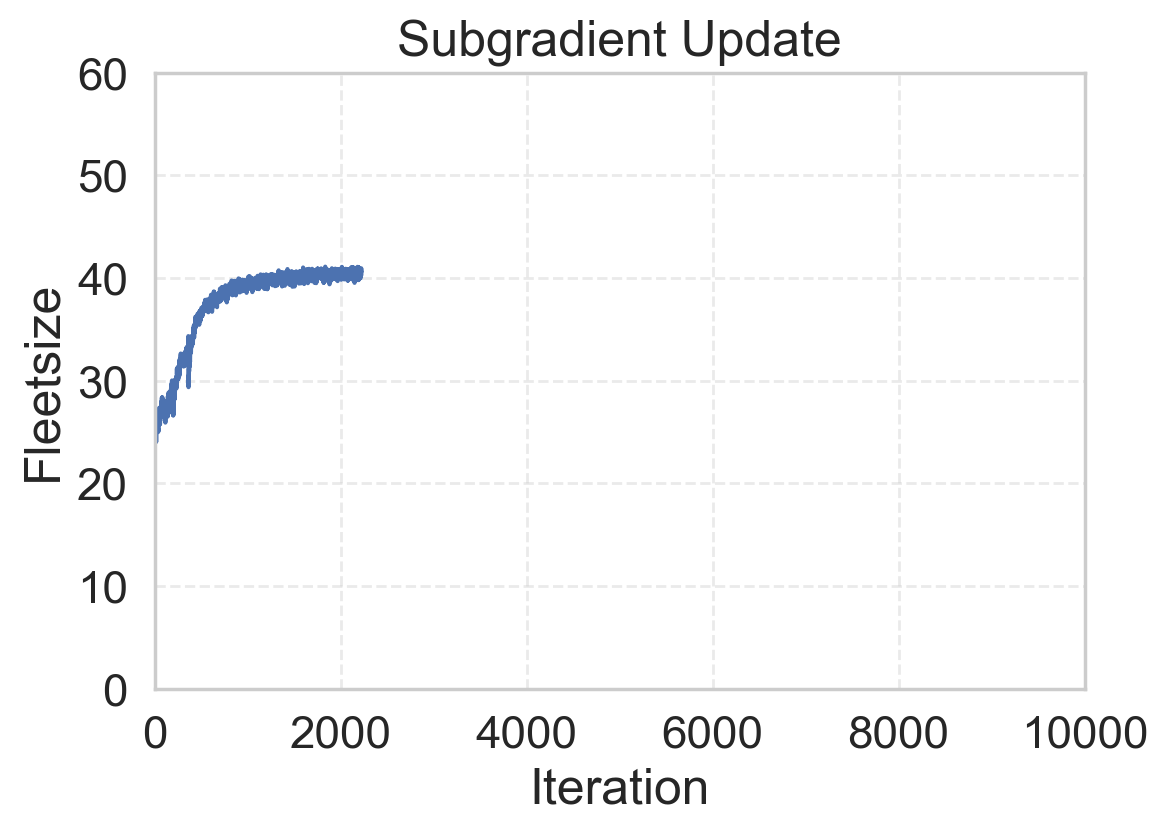

In [104]:
fig, ax = plt.subplots(dpi=200, figsize=(6,4))
sns.lineplot(best_fleetsize, ax=ax)
ax.set(xlim=(0, 10000), ylim=(0, 60), 
       xlabel='Iteration', ylabel='Fleetsize', title='Subgradient Update');

minorLocator = MultipleLocator(1)
ax.grid(True, alpha=0.4, linestyle='--', which='both')
plt.savefig('../output/star_network/LR/fleetsize.png', bbox_inches='tight')

NameError: name 'np' is not defined

In [ ]:
T = 3
K = 3
V = 2


nodes = ['Source', 'Sink']
nodes = nodes + [(v, t, k) for v in range(V) for t in range(T) for k in range(K)]

augmented_edges = [('Source', 'Sink')]
cost = [0]

source2vertiport = [('Source', (v, 0, k)) for v in range(V) for k in range(K)]
cost = cost + [1 for _ in range(len(source2vertiport))]

vertiport2sink = [((v, 2, k), 'Sink') for v in range(V) for k in range(K)]
cost = cost + [0 for _ in range(len(vertiport2sink))]

idling = [((v,t,k), (v,t+1,k)) for v in range(V) for t in range(T-1) for k in range(K)]
cost = cost + [0 for _ in range(len(idling))]

charging = [((v,t,k), (v,t+1,k+1)) for v in range(V) for t in range(T-1) for k in range(K-1)] + [((v,0,0),(v,2,2)) for v in range(V)]
cost = cost + [0 for _ in range(len(charging))]

flight = []
for v in range(V):
    for w in range(V):
        if v != w:
            for t in range(T-1):
                for k in range(1,K):
                    flight.append(((v,t,k), (w,t+1,k-1)))
cost = cost + [0 for _ in range(len(flight))]

edges = augmented_edges + source2vertiport + vertiport2sink + idling + charging + flight

c = dict(zip(edges, cost))

supply = {'Source': -20, 'Sink': 20}

In [ ]:
from gurobipy import Model, quicksum

In [ ]:
def get_flight_edges(i, model_param):
    v1, v2, t = i
    return quicksum(model_param[(v1, t, k), (v2, t+1, k-1)] for k in range(1,K))
 
def dual_relax_MCNF(lambda_s, flight_demand):
    m = Model("LagrangianRelaxationExample")
    m.setParam('OutputFlag', 0)
    flow = m.addVars(edges, name="flow", lb=0)
    for n in nodes:
        m.addConstr(sum(flow[i, j] for i, j in edges if j == n) -
                    sum(flow[i, j] for i, j in edges if i == n) == supply.get(n, 0), f"node_{n}")

    primal_objective = quicksum(c[i,j] * flow[i,j] for i,j in edges)
    lagragian_dual_objective = quicksum(lambda_s[i] * (flight_demand[i] - get_flight_edges(i, flow)) for i in flight_demand.keys())
    m.setObjective(primal_objective + lagragian_dual_objective, GRB.MINIMIZE)
    m.optimize()

    subgradeints = {i: flight_demand[i] - get_flight_edges(i, flow).getValue() for i in flight_demand.keys()}

    solution = m.getAttr('x', flow)
    flow_sum = sum(solution[i, j] for (i, j) in edges if i == 'Source' and j == 'Sink')

    return primal_objective.getValue(), lagragian_dual_objective.getValue(), subgradeints, flow_sum

In [ ]:
flight_demand = {(0, 1, 0):2, (1, 0, 0):9, (0, 1, 1):3, (1, 0, 1):4}
lambda_s = {i:0 for i in flight_demand.keys()}

max_iter = 100
alpha = 0.9
epsilon = 0.1
step_size = 0.05

ofv = []
multipliers_to_plot = np.empty((max_iter, len(flight_demand)))

for iteration in range(max_iter):
    primal_ofv, lr_ofv, subgradients, flow_sum = dual_relax_MCNF(lambda_s, flight_demand)
    for i in flight_demand.keys():
        lambda_s[i] = max(0, lambda_s[i] + step_size * subgradients[i])

    step_size *= alpha

    if all(abs(subgradient) < epsilon for subgradient in list(subgradients.values())):
        print("Convergence achieved after", iteration, "iterations")
        break

    print("Iteration:", iteration)
    print("Primal Objective:", primal_ofv)
    print("Lagrangian Dual Objective:", lr_ofv)
    print('Total Cost:', primal_ofv + lr_ofv)
    print('Source-Sink Flow:', flow_sum)
    print('Lagraingian Multipliers:', np.array(list(lambda_s.values())).round(2), "\n")
    multipliers_to_plot[iteration] = list(lambda_s.values())
    ofv.append(primal_ofv + lr_ofv)
    # if lr_ofv > 0:
    #     print("Lagrangian Dual Objective is positive. Stop the algorithm.")
    #     print(lambda_s)
    #     break
        


Iteration: 0
Primal Objective: 0.0
Lagrangian Dual Objective: 0.0
Total Cost: 0.0
Source-Sink Flow: 20.0
Lagraingian Multipliers: [0.1  0.45 0.15 0.2 ] 

Iteration: 1
Primal Objective: 0.0
Lagrangian Dual Objective: 5.5
Total Cost: 5.5
Source-Sink Flow: 20.0
Lagraingian Multipliers: [0.19 0.86 0.29 0.38] 

Iteration: 2
Primal Objective: 20.0
Lagrangian Dual Objective: -12.350000000000001
Total Cost: 7.649999999999999
Source-Sink Flow: 0.0
Lagraingian Multipliers: [0.27 0.41 0.   0.54] 

Iteration: 3
Primal Objective: 0.0
Lagrangian Dual Objective: 6.395499999999999
Total Cost: 6.395499999999999
Source-Sink Flow: 20.0
Lagraingian Multipliers: [0.34 0.74 0.11 0.69] 

Iteration: 4
Primal Objective: 20.0
Lagrangian Dual Objective: -10.229000000000003
Total Cost: 9.770999999999997
Source-Sink Flow: 0.0
Lagraingian Multipliers: [0.   1.03 0.21 0.16] 

Iteration: 5
Primal Objective: 20.0
Lagrangian Dual Objective: -14.24107
Total Cost: 5.758929999999999
Source-Sink Flow: 0.0
Lagraingian Multi

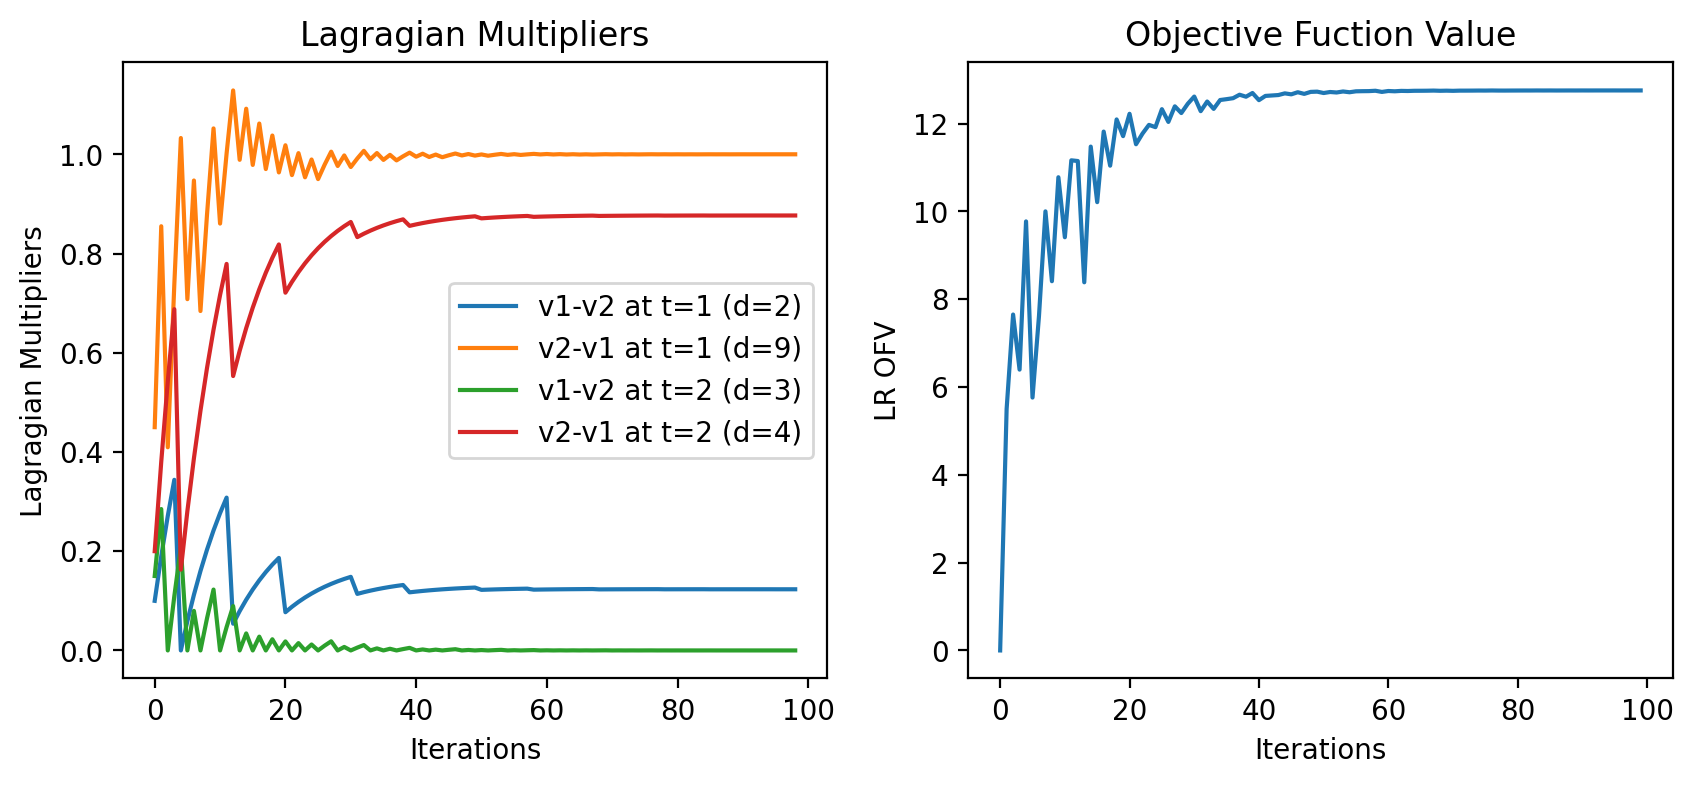

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=200)

ax[0].plot(multipliers_to_plot[:iteration])
ax[0].set(xlabel='Iterations', ylabel='Lagragian Multipliers', title='Lagragian Multipliers')
ax[0].legend(['v1-v2 at t=1 (d=2)', 'v2-v1 at t=1 (d=9)', 'v1-v2 at t=2 (d=3)', 'v2-v1 at t=2 (d=4)'])


ax[1].plot(ofv)
ax[1].set(xlabel='Iterations', ylabel='LR OFV', title='Objective Fuction Value')
plt.show()



In [ ]:
from gurobipy import Model, GRB, quicksum

# Initialize model
m = Model("LagrangianRelaxationExample")

flow = m.addVars(edges, name="flow", lb=0)

for n in nodes:
    m.addConstr(sum(flow[i, j] for i, j in edges if j == n) -
                sum(flow[i, j] for i, j in edges if i == n) == supply.get(n, 0), f"node_{n}")


# demand is written in terms of (v1,v2,t)
flight_demand = {(0, 1, 0):4, (1, 0, 0):4, (0, 1, 1):4, (1, 0, 1):4}
lambda_s = {i:0.1 for i in flight_demand.keys()}


primal_objective = quicksum(c[i,j] * flow[i,j] for i,j in edges)
def get_flight_edges(i, model_param):
    v1, v2, t = i
    return quicksum(model_param[(v1, t, k), (v2, t+1, k-1)] for k in range(1,K))
 

max_iter = 100
alpha = 0.8
epsilon = 0.01
step_size = 0.05
m.setParam('OutputFlag', 0)
for iteration in range(max_iter):
    lagragian_dual_objective = quicksum(lambda_s[i] * (flight_demand[i] - get_flight_edges(i, flow)) for i in flight_demand.keys())
    m.setObjective(primal_objective + lagragian_dual_objective, GRB.MINIMIZE)
    m.optimize()

    if m.status != GRB.OPTIMAL:
        print("No optimal solution found in iteration", iteration)
        break

    subgradients = [flight_demand[i] - get_flight_edges(i, flow).getValue() for i in flight_demand.keys()]

    for i in lambda_s.keys():
        subgradient = flight_demand[i] - get_flight_edges(i, flow).getValue()
        lambda_s[i] = max(0, lambda_s[i] + step_size * subgradient)

    step_size *= alpha

    # Check for convergence (e.g., if the magnitude of all subgradients is small)
    if all(abs(subgradient) < epsilon for subgradient in subgradients):
        print("Convergence achieved after", iteration, "iterations")
        break


    solution = m.getAttr('x', flow)
    flow_sum = sum(solution[i, j] for (i, j) in edges if i == 'Source' and j == 'Sink')
    print("iteration:", iteration)
    print("lambda_s:", lambda_s.values())
    print("primal", primal_objective.getValue(), "lagragian_dual_objective:", lagragian_dual_objective.getValue())
    print('OFV:' ,primal_objective.getValue() + lagragian_dual_objective.getValue())
    print("Sum of flow from Source to Sink:", flow_sum ,"\n")



# lagragian_dual_objective = quicksum(lambda_s[i] * ( flight_demand[i] - get_flight_edges(i)) for i in flight_demand.keys())

# m.setObjective(primal_objective + lagragian_dual_objective, GRB.MINIMIZE)

# m.optimize()

# if m.status == GRB.OPTIMAL:
#     solution = m.getAttr('x', flow)
#     flow_sum = sum(solution[i, j] for (i, j) in edges if i == 'Source' and j == 'Sink')
#     print("lagragian_dual_objective:", lagragian_dual_objective.getValue())
#     print("Sum of flow from Source to Sink:", flow_sum)
# else:
#     print("No optimal solution found.")


iteration: 0
lambda_s: dict_values([0.30000000000000004, 0.30000000000000004, 0.30000000000000004, 0.30000000000000004])
primal 0.0 lagragian_dual_objective: 1.6
OFV: 1.6
Sum of flow from Source to Sink: 20.0 

iteration: 1
lambda_s: dict_values([0.4600000000000001, 0.4600000000000001, 0.4600000000000001, 0.4600000000000001])
primal 0.0 lagragian_dual_objective: 4.800000000000001
OFV: 4.800000000000001
Sum of flow from Source to Sink: 20.0 

iteration: 2
lambda_s: dict_values([0.5880000000000001, 0.5880000000000001, 0.5880000000000001, 0.5880000000000001])
primal 0.0 lagragian_dual_objective: 7.360000000000001
OFV: 7.360000000000001
Sum of flow from Source to Sink: 20.0 

iteration: 3
lambda_s: dict_values([0.6904000000000001, 0.17839999999999995, 0.17839999999999995, 0.6904000000000001])
primal 20.0 lagragian_dual_objective: -14.112000000000002
OFV: 5.887999999999998
Sum of flow from Source to Sink: 0.0 

iteration: 4
lambda_s: dict_values([0.36272, 0.26032, 0.26032, 0.36272])
primal 